importing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

importing the data

In [ ]:
df = pd.read_csv("takehome_users.csv",encoding='latin-1')
dfe = pd.read_csv("takehome_user_engagement.csv")


analysing engagement dataset

In [ ]:
dfe.head(5)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1.0,1.0
1,2013-11-15 03:45:04,2.0,1.0
2,2013-11-29 03:45:04,2.0,1.0
3,2013-12-09 03:45:04,2.0,1.0
4,2013-12-25 03:45:04,2.0,1.0


In [ ]:
dfe.dtypes

time_stamp     object
user_id       float64
visited       float64
dtype: object

In [ ]:
#covert time stamp to datetime
dfe["time_stamp"]=pd.to_datetime(dfe["time_stamp"])

In [ ]:
dfe.dtypes

time_stamp    datetime64[ns]
user_id              float64
visited              float64
dtype: object

In [ ]:
#check for null values
dfe.isnull().sum() #no null values

time_stamp    0
user_id       1
visited       1
dtype: int64

trying to find the adopted users

In [ ]:
# For determining which users can be labeled as adopted users, we can use groupby and rolling methods to find the users who were active for more than 3 days in any of the 7 day rolling period.

In [ ]:
#creating a copy
dfau = dfe.copy()

In [ ]:
dfau["date"]=dfau["time_stamp"].dt.date

In [ ]:
dfau.head(1)

,time_stamp,user_id,visited,date
0,2014-04-22 03:53:30,1.0,1.0,2014-04-22


In [ ]:
#rolling function
def rolling_count(df_group, frequency):
    return df_group.rolling(frequency, on='date')['user_id'].count()

In [ ]:
dfau.date = pd.to_datetime(dfau.date)

In [ ]:
dfau['visits_7_days'] = dfau.groupby('user_id', as_index=False, group_keys=False).apply(rolling_count, '7D')

In [ ]:
user_adopted = dfau.groupby('user_id')['visits_7_days'].max().reset_index()

In [ ]:
user_adopted['adopted_user'] = user_adopted['visits_7_days'].apply(lambda x: 1 if x>=3 else 0)

In [ ]:
user_adopted.head(2)

,user_id,visits_7_days,adopted_user
0,1.0,1.0,0
1,2.0,3.0,1


In [ ]:
x =user_adopted.adopted_user.value_counts()
x= pd.DataFrame(x)
x

,adopted_user
0,5206
1,1143


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


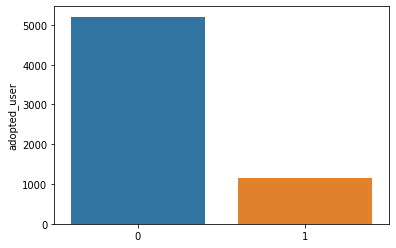

In [ ]:
sns.barplot(x.index,x.adopted_user)


merging the 2 datasets

In [ ]:
user_adopted.drop('visits_7_days', axis = 1, inplace = True)
user_adopted.rename(columns={"user_id": "object_id"}, inplace=True)

In [ ]:
user_adopted.set_index("object_id", inplace = True)

In [ ]:
df = df.join(user_adopted, on = 'object_id', how='left')

analysing the merged data set

In [ ]:
df.head(2)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0


In [ ]:
df.dtypes

object_id                              int64
creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                       object
last_session_creation_time           float64
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
adopted_user                         float64
dtype: object

In [ ]:
#creation time convert to date time format
df["creation_time"]=pd.to_datetime(df["creation_time"])

In [ ]:
df.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
adopted_user                  5651
dtype: int64

In [ ]:
# The null values in the adopted_user and last_session_creation_time can be filled in with 0 because we can assume that those users aren't adopted users.
df['last_session_creation_time'].fillna(0, inplace = True)
df['adopted_user'].fillna(0, inplace = True)

In [ ]:
#drop object id , name and email columns
df.drop(['object_id', 'name', 'email', ], axis = 1, inplace = True)

In [ ]:
df.isnull().sum()

creation_time                 0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
adopted_user                  0
dtype: int64

In [ ]:
#fill invited by user id missing values as 0:
df.invited_by_user_id.fillna(0,inplace = True)

In [ ]:
#calculating age of account in days
df['days_since_creation'] = (dfe.time_stamp.max() - df.creation_time).dt.days

In [ ]:
df.drop(['creation_time', 'last_session_creation_time'], axis = 1, inplace = True)

In [ ]:
df.head(1)

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,days_since_creation
0,GUEST_INVITE,1,0,11,10803.0,0.0,45


In [ ]:
# OneHotEncode the creation_source column.
df= pd.get_dummies(df, columns=['creation_source'])

viualization

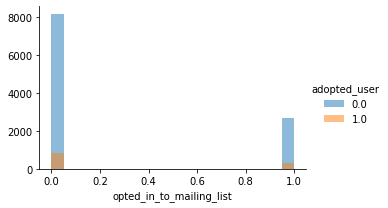

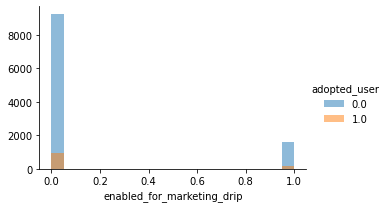

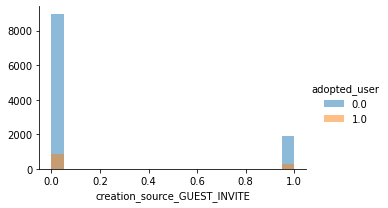

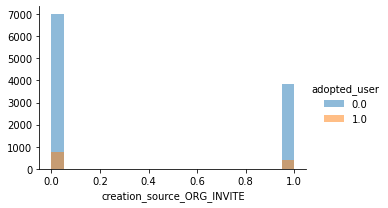

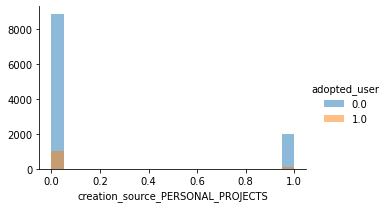

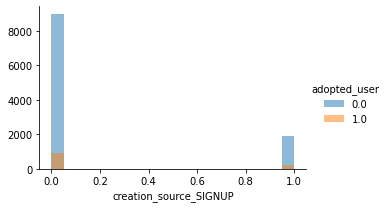

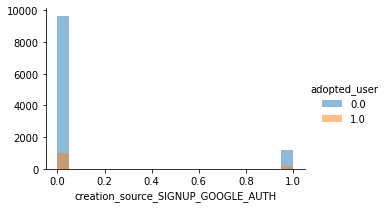

In [ ]:
for col in ['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'creation_source_GUEST_INVITE',
           'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP',
           'creation_source_SIGNUP_GOOGLE_AUTH']:
    g = sns.FacetGrid(df, hue = "adopted_user", height=3, aspect=1.5,)
    g.map(plt.hist, col, alpha=.5, bins = 20)
    g.add_legend()    

*user who opted to mailing list have more adopted users
*adopted users opted more for marketing drip
*